---

# Desafío - Modelos de ensamble (parte I)(G93)

---

Este framework sigue un enfoque iterativo, aunque el trabajo se presenta de manera lineal.

En la práctica, es común regresar a etapas anteriores para realizar ajustes y optimizar el proceso.

Por ejemplo, puede ser necesario transformar variables antes de analizar correlaciones o generar visualizaciones significativas.

Este enfoque flexible permite garantizar que cada paso contribuya de manera efectiva a la construcción de un modelo preciso y robusto.

---

Nombre: SERGIO C. DELGADO MARTINEZ

Profesor: GABRIEL A. CESPEDES ALARCON

Desafio: Detección temprana de renuncias en
empresa de telecomunicaciones

Curso: Modelos avanzados y Redes Neuronales (G93)


## **Resumen Ejecutivo**

El desafío propone construir y analizar distintos modelos de ensamble para la **detección temprana de renuncias de clientes** en una empresa de telecomunicaciones. Se trabaja con un dataset que contiene variables relacionadas con el comportamiento y los servicios de los clientes. El objetivo es predecir el abandono (churn) y explicar qué factores influyen más en esa decisión.


---

## **Contenido del Dataset (`telecom_churn.csv`)**

| Variable          | Descripción                                     |
|------------------|-------------------------------------------------|
| `Churn`          | Variable objetivo (1 = renuncia, 0 = permanece) |
| `AccountWeeks`   | Semanas con la cuenta activa                    |
| `ContractRenewal`| Si renovó contrato recientemente (1/0)          |
| `DataPlan`       | Si tiene plan de datos (1/0)                    |
| `DataUsage`      | Uso mensual de datos (GB)                       |
| `CustServCalls`  | Nº de llamadas al servicio al cliente           |
| `DayMins`        | Promedio de minutos diurnos al mes              |
| `DayCalls`       | Nº medio de llamadas diurnas                    |
| `MonthlyCharge`  | Cargo mensual promedio                          |
| `OverageFee`     | Máximo recargo por exceso en últimos 12 meses   |
| `RoamMin`        | Minutos de uso en roaming                       |

---

## **Tareas Específicas**

### 1. **Exploración de Datos**
- Importar librerías
- Cargar datos
- Visualizar variables
- Analizar correlaciones (usar heatmap)

### 2. **Árbol de Decisión**
- Entrenar árbol sin ajustar hiperparámetros
- Evaluar métricas
- Optimizar con Grid Search (5-fold CV) para `max_depth` y `min_samples_split`
- Reportar hiperparámetros óptimos y desempeño (train/test)

### 3. **Bagging con SMOTE**
- Aplicar SMOTE al set de entrenamiento para balancear clases
- Entrenar modelo de Bagging con 200 estimadores (homogéneo)
- Evaluar desempeño en set de test

### 4. **Bagging Heterogéneo**
- Entrenar modelo con:
  - Regresión Logística
  - Árbol de decisión
  - SVM (kernel RBF)
  - SVM (kernel Sigmoid)
- Usar 200 muestras bootstrap
- Evaluar f1-score y repetir el mejor modelo para calibrar importancia
- Utilizar `bagging_het` del archivo `util_bagging.py`
- Reportar métricas finales en test

### 5. **Random Forest Básico**
- Usar `n_estimators = 45`
- Evaluar OOB accuracy
- Identificar 4 características más importantes
- Evaluar desempeño en test

### 6. **Random Forest con Grid Search**
- Hiperparámetros a buscar:
  - `n_estimators`: 50 a 200 (paso de 10, total 15 valores)
  - `max_features`: [`sqrt`, `log2`, `None`]
- Reportar:
  - Mejores hiperparámetros
  - OOB accuracy
  - Importancia de atributos
  - Análisis de métricas, curva ROC y AUC

### 7. **Clientes con Mayor Riesgo de Renuncia**
- Con el modelo final optimizado de Random Forest:
  - Identificar y mostrar los **15 clientes con mayor probabilidad de renunciar**

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB

Muestra aleatoria de registros:


,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
438,0,113,1,0,0.00,1,155.0,93,55.0,16.53,13.5
2674,0,67,1,0,0.00,0,109.1,117,38.0,10.87,12.8
1345,1,98,1,0,0.00,4,0.0,0,14.0,7.98,6.8
1957,0,147,1,0,0.33,1,212.8,79,57.3,10.21,10.2
2148,0,96,1,0,0.30,1,144.0,102,47.0,11.24,10.0



Duplicados detectados: 0

Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
Churn,3333.0,0.144914,0.352067,0.0,0.00,0.00,0.00,1.00
AccountWeeks,3333.0,101.064806,39.822106,1.0,74.00,101.00,127.00,243.00
ContractRenewal,3333.0,0.903090,0.295879,0.0,1.00,1.00,1.00,1.00
DataPlan,3333.0,0.276628,0.447398,0.0,0.00,0.00,1.00,1.00
DataUsage,3333.0,0.816475,1.272668,0.0,0.00,0.00,1.78,5.40
CustServCalls,3333.0,1.562856,1.315491,0.0,1.00,1.00,2.00,9.00
DayMins,3333.0,179.775098,54.467389,0.0,143.70,179.40,216.40,350.80
DayCalls,3333.0,100.435644,20.069084,0.0,87.00,101.00,114.00,165.00
MonthlyCharge,3333.0,56.305161,16.426032,14.0,45.00,53.50,66.20,111.30
OverageFee,3333.0,10.051488,2.535712,0.0,8.33,10.07,11.77,18.19



Valores nulos por columna:
Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64

Distribución de la variable 'Churn':
Churn
0    2850
1     483
Name: count, dtype: int64

Distribución relativa de 'Churn':
Churn
0    0.855
1    0.145
Name: proportion, dtype: float64


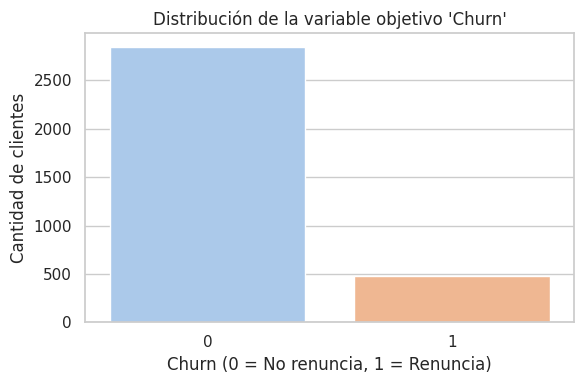

In [ ]:
# Exploración de Datos: telecom_churn.csv

# Carga del dataset
df = pd.read_csv("telecom_churn.csv")

# Información general del dataset
print("Información general del dataset:")
df.info()

# Muestra aleatoria de registros
print("\nMuestra aleatoria de registros:")
display(df.sample(5, random_state=42))

# Revisión de duplicados
dup_count = df.duplicated().sum()
print(f"\nDuplicados detectados: {dup_count}")
if dup_count > 0:
    df = df.drop_duplicates()
    print(f"Duplicados eliminados. Total de registros: {df.shape[0]}")

# Estadísticas descriptivas de variables numéricas
print("\nEstadísticas descriptivas:")
display(df.describe().T)

# Revisión de valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Distribución de la variable objetivo
print("\nDistribución de la variable 'Churn':")
print(df['Churn'].value_counts())

print("\nDistribución relativa de 'Churn':")
print(df['Churn'].value_counts(normalize=True).round(3))

# Visualización de la variable objetivo
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='pastel')
plt.title("Distribución de la variable objetivo 'Churn'")
plt.xlabel("Churn (0 = No renuncia, 1 = Renuncia)")
plt.ylabel("Cantidad de clientes")
plt.tight_layout()
plt.show()

## Análisis Crítico Basado en Datos

### Desbalance en la variable objetivo (`Churn`)
El 14,5% de los clientes en el dataset corresponde a casos de renuncia (`Churn = 1`), mientras que el 85,5% permanece. Este desbalance severo invalida el uso exclusivo de métricas como `accuracy`, ya que un modelo que prediga siempre la clase mayoritaria alcanzaría un 85% de precisión sin aprender nada útil. Por tanto, se utilizarán métricas más adecuadas como `recall`, `f1-score` y curvas `ROC/AUC`, que penalizan los errores sobre la clase minoritaria.

Además, las visualizaciones de variables predictoras deben desagregarse por clase (`Churn = 0` y `Churn = 1`) para evitar que los promedios oculten diferencias relevantes.

### Variables con fuerte sesgo y concentración en ceros
- `DataUsage`: El 50% de los clientes tiene un uso mensual de datos igual a 0 GB, mientras que algunos alcanzan hasta 5.4 GB. Esto sugiere una distribución altamente asimétrica. Además, su valor depende directamente de si el cliente tiene `DataPlan`.
- `ContractRenewal`: El 90% de los clientes renovó contrato recientemente (`valor = 1`), lo que indica una variable muy desequilibrada pero potencialmente predictiva.
- `DataPlan`: Solo el 28% de los clientes tiene plan de datos (`valor = 1`). Dado que `DataUsage = 0` cuando no hay plan, estas dos variables están estructuralmente ligadas y se evaluará su tratamiento conjunto.
- `CustServCalls`: Aunque su valor máximo es 9, la mayoría de los clientes realiza entre 0 y 2 llamadas al servicio al cliente. La variable es fuertemente sesgada y puede estar asociada al nivel de insatisfacción del cliente.

### Potenciales outliers en variables continuas
- `DayMins`: Varía desde 0 hasta 350.8 minutos, con una mediana de 179.4. Los valores extremos podrían representar clientes inactivos o altamente intensivos, y deben analizarse con más detalle.
- `MonthlyCharge`: Fluctúa entre 14.0 y 111.3 USD, con una media de 56.3. Tiene alta probabilidad de correlación con `DayMins` y `OverageFee`, por lo que se evaluará su redundancia o complementariedad con otras variables relacionadas al costo.

Estas observaciones guían las decisiones de preprocesamiento, selección de métricas y estrategias de modelado que se adoptarán en las siguientes etapas.

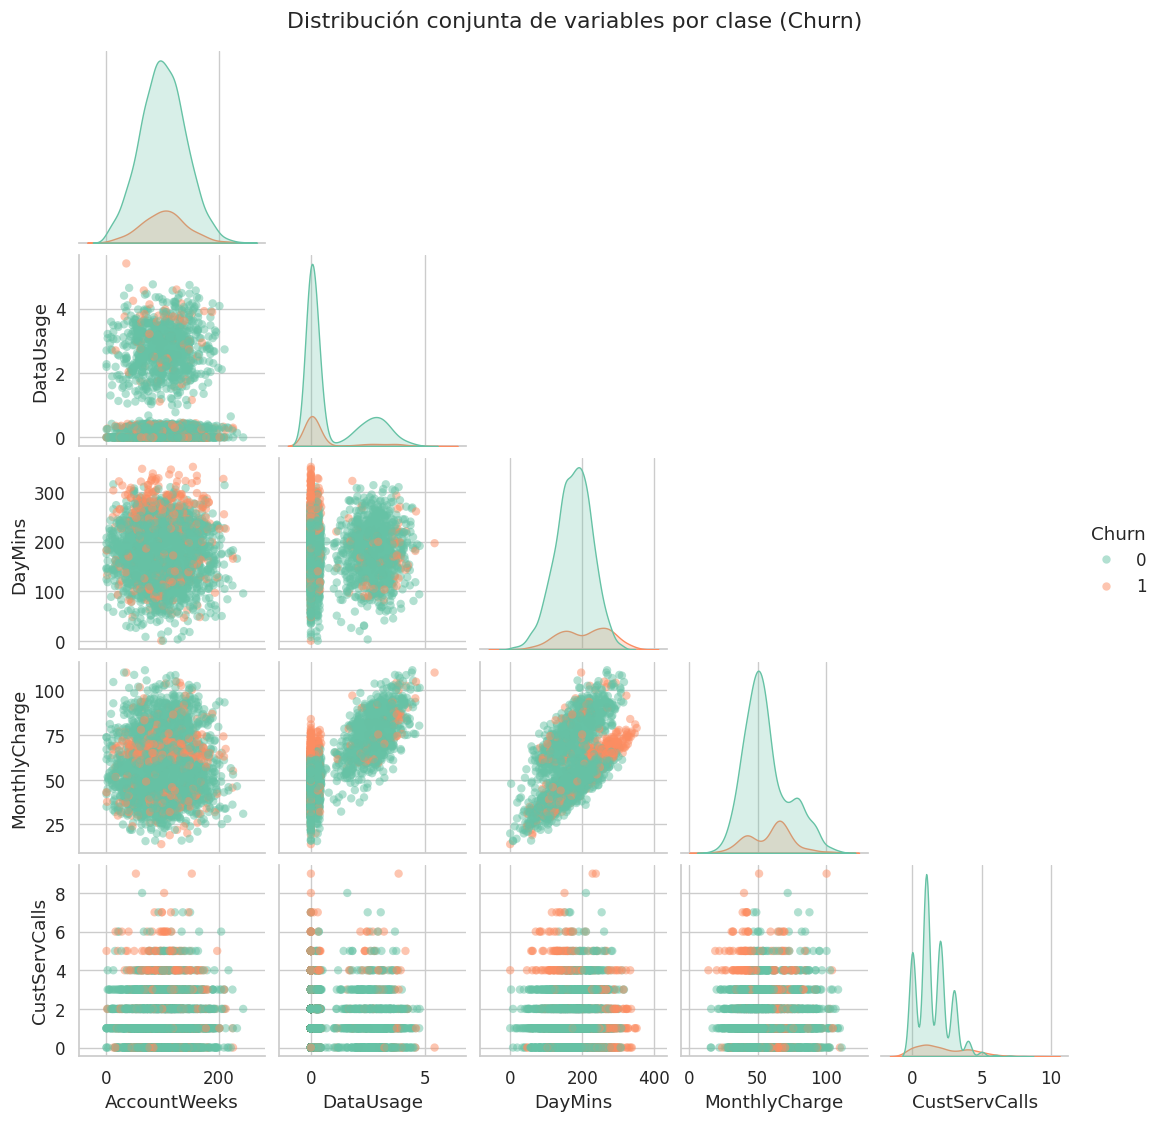

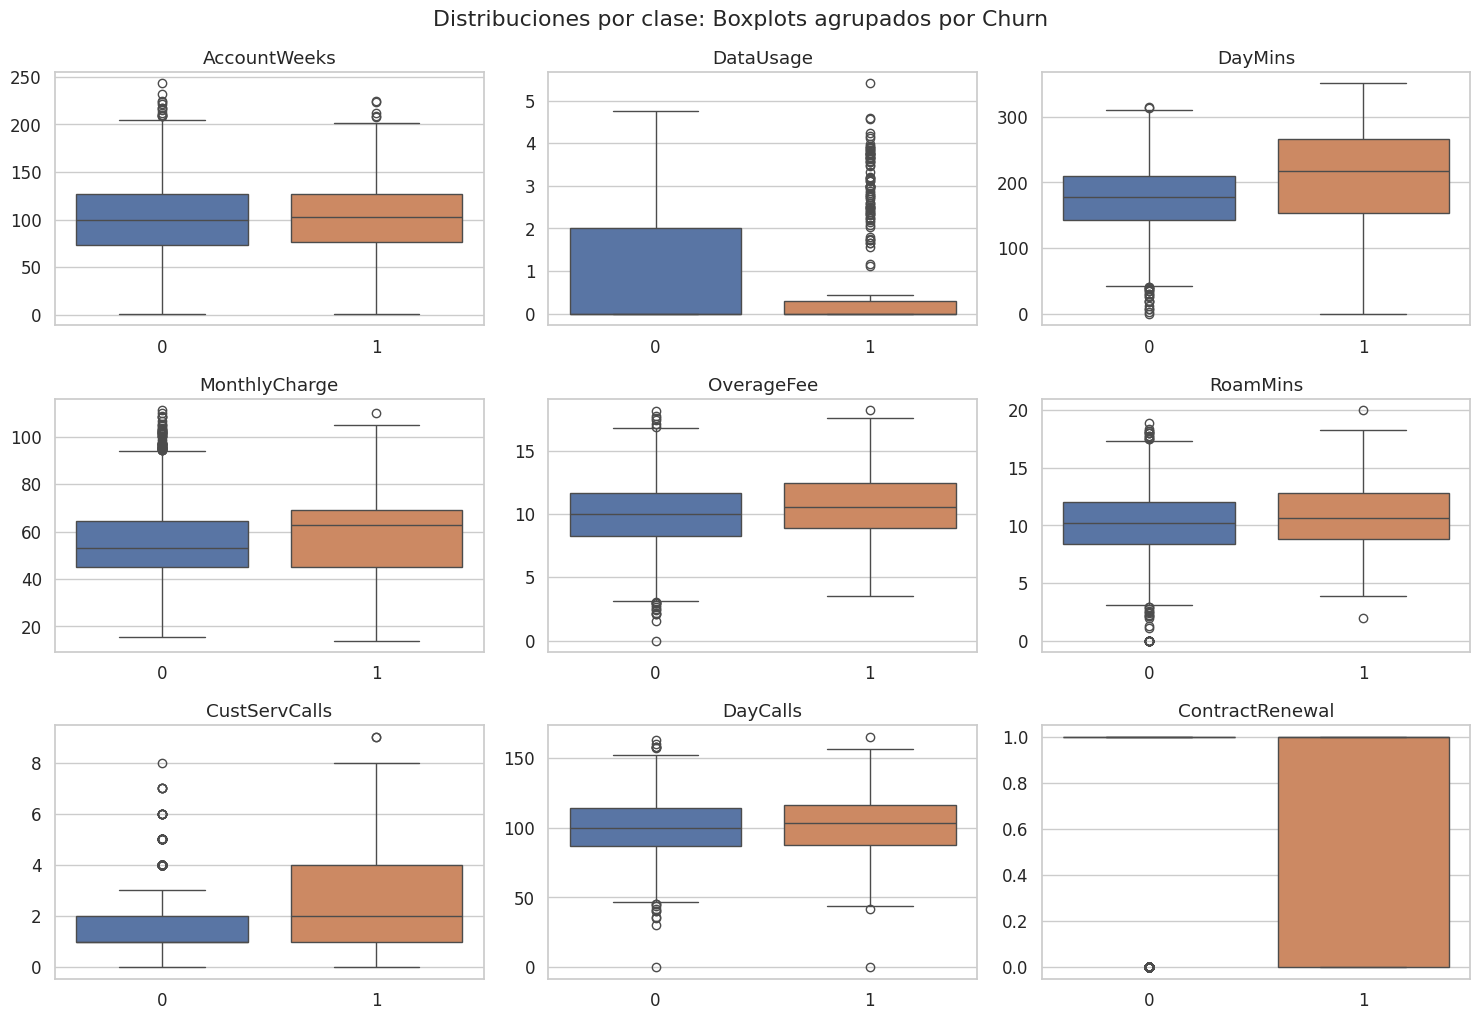

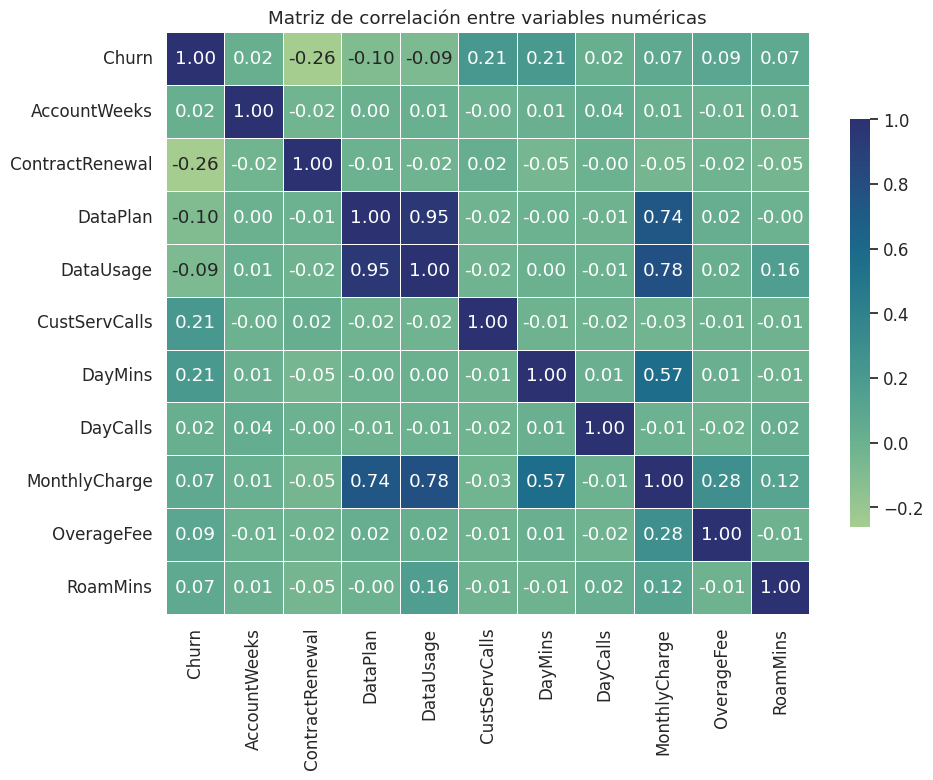

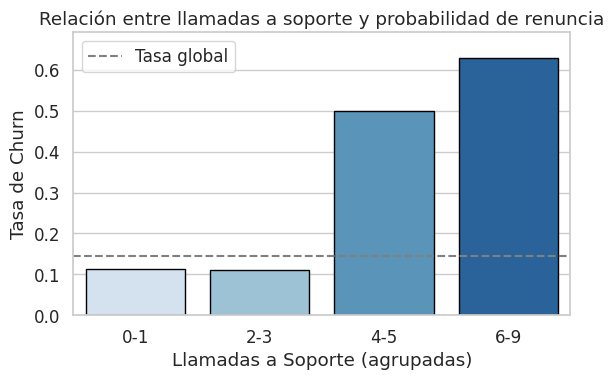

In [ ]:
# Exploración visual avanzada

# Configuración de estilo visual
sns.set_theme(context="notebook",
              style="whitegrid",
              palette="Set2",
              font_scale=1.1)

# Pair Plot con variables seleccionadas
pair_vars = ['AccountWeeks', 'DataUsage',
             'DayMins', 'MonthlyCharge',
             'CustServCalls', 'Churn']

sns.pairplot(df[pair_vars],
             hue="Churn",
             diag_kind="kde",
             corner=True,
             palette="Set2",
             plot_kws=dict(alpha=0.5, linewidth=0),
             height=2.2)
plt.suptitle("Distribución conjunta de variables por clase (Churn)", y=1.02)
plt.show()

# Boxplots 3×3 por clase Churn
box_vars = ['AccountWeeks', 'DataUsage', 'DayMins',
            'MonthlyCharge', 'OverageFee', 'RoamMins',
            'CustServCalls', 'DayCalls', 'ContractRenewal']

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharey=False)
axes = axes.flatten()

for ax, col in zip(axes, box_vars):
    sns.boxplot(x="Churn",
                y=col,
                data=df,
                ax=ax,
                palette=["#4c72b0", "#dd8452"],
                hue_order=[0, 1])
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.suptitle("Distribuciones por clase: Boxplots agrupados por Churn", y=1.02)
plt.show()

# Heatmap de correlaciones numéricas
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            cmap="crest",
            linewidths=0.5,
            cbar_kws={"shrink": .7})
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()

# Análisis de churn según llamadas a soporte
df['CSCalls_bin'] = pd.cut(df['CustServCalls'],
                           bins=[-0.1, 1, 3, 5, 9],
                           labels=['0-1', '2-3', '4-5', '6-9'])

churn_rate = (
    df.groupby('CSCalls_bin')['Churn']
      .mean()
      .reset_index()
      .rename(columns={'Churn': 'Churn_Rate'})
)

plt.figure(figsize=(6, 4))
sns.barplot(data=churn_rate,
            x='CSCalls_bin',
            y='Churn_Rate',
            palette="Blues",
            edgecolor="black")

plt.axhline(df['Churn'].mean(), ls='--', color='gray', label='Tasa global')
plt.ylabel("Tasa de Churn")
plt.xlabel("Llamadas a Soporte (agrupadas)")
plt.title("Relación entre llamadas a soporte y probabilidad de renuncia")
plt.ylim(0, churn_rate['Churn_Rate'].max()*1.1)
plt.legend()
plt.tight_layout()
plt.show()

## Evaluación de Visualizaciones Exploratorias

### 1. Pair Plot – Variables seleccionadas vs Churn

**Interpretación:**

- `DayMins` y `MonthlyCharge` presentan una relación positiva clara: a mayor uso, mayor cargo. Sin embargo, los casos de `Churn = 1` tienden a concentrarse en valores altos de `DayMins`, con alta dispersión en `MonthlyCharge`, lo que sugiere percepción de sobrecosto en algunos clientes intensivos.
- `CustServCalls` muestra patrones verticales (variable discreta), y a partir de 4 llamadas se observa una clara concentración de clientes que renuncian.
- `DataUsage` presenta una distribución mayormente baja o nula. Los valores altos no diferencian con claridad entre clases, lo que limita su utilidad discriminante, especialmente considerando su dependencia estructural con `DataPlan`.

**Evaluación:**

- Útil para detectar tendencias generales, aunque algunos pares de variables no muestran separación clara entre clases.
- La dispersión y no linealidad observada refuerzan la idea de utilizar modelos no lineales (como árboles o SVM con kernel) para capturar relaciones complejas.

---

### 2. Boxplots 3x3 por clase (`Churn`)

**Hallazgos relevantes:**

- `DayMins` y `MonthlyCharge` son más altos en promedio para quienes renuncian, lo que puede relacionarse con la percepción de tarifas elevadas.
- `CustServCalls` está fuertemente sesgada a la derecha para `Churn = 1`, con varios clientes que han realizado entre 4 y 9 llamadas. Esto sugiere un vínculo fuerte entre frustración del cliente y renuncia.
- `ContractRenewal` se comporta como un indicador binario muy claro: casi todos los que renuncian no renovaron contrato recientemente.
- `DataUsage` sigue mostrando baja variabilidad y poco poder de discriminación, con predominancia de valores bajos en ambas clases.

**Evaluación:**

- Excelente herramienta para analizar la distribución por clase.
- Útil tanto para la construcción de modelos explicativos como para comunicación ejecutiva de hallazgos.

---

### 3. Heatmap de correlaciones

**Puntos clave:**

- `Churn` muestra correlación negativa moderada con `ContractRenewal` (-0.26), lo que respalda su valor como predictor clave.
- Correlaciones positivas más débiles se observan con `DayMins` y `CustServCalls` (≈ +0.20).
- Fuerte colinealidad entre `DataPlan` y `DataUsage` (≈ +0.95), y también entre `DayMins`, `MonthlyCharge` y `OverageFee`, lo que indica la posibilidad de redundancia en estas dimensiones de costo/uso.

**Evaluación:**

- No se detectan correlaciones extremas entre predictores (mayores a ±0.95, excepto las ya explicadas), por lo que no se eliminarán variables de forma automática. Se priorizará la evaluación de importancia durante el modelado.
- El bajo nivel de correlación lineal con `Churn` sugiere que los modelos lineales simples tendrán dificultad para separar clases, reforzando la elección de modelos no lineales como Random Forest o SVM.

---

### 4. Barplot – Tasa de `Churn` por tramos de `CustServCalls`

**Observaciones clave:**

- Tasa de churn inferior al 13% para clientes con 0 a 3 llamadas al servicio al cliente.
- La tasa se eleva al 50% para quienes han realizado entre 4 y 5 llamadas.
- Supera el 60% para el grupo con 6 a 9 llamadas.

**Conclusión de negocio:**

- El número de contactos con soporte es un indicador directo de riesgo de renuncia.
- Umbral crítico: **más de 3 llamadas a soporte multiplica por 5 la probabilidad de churn**.
- Esta variable es altamente accionable para diseñar alertas tempranas o programas proactivos de retención.

**Evaluación:**

- La visualización más útil desde una perspectiva táctica.
- Comunica de forma clara y efectiva un umbral de riesgo operacional.

---

**Conclusión general del análisis visual:**

Estas visualizaciones permiten identificar variables predictoras relevantes (`ContractRenewal`, `CustServCalls`, `AccountWeeks`, `DayMins`, `MonthlyCharge`), detectar relaciones no lineales que justifican el uso de modelos más robustos, y aportar argumentos concretos para futuras decisiones de ingeniería de variables y estrategia de modelado.


Matriz de Confusión:
[[538  32]
 [ 40  57]]


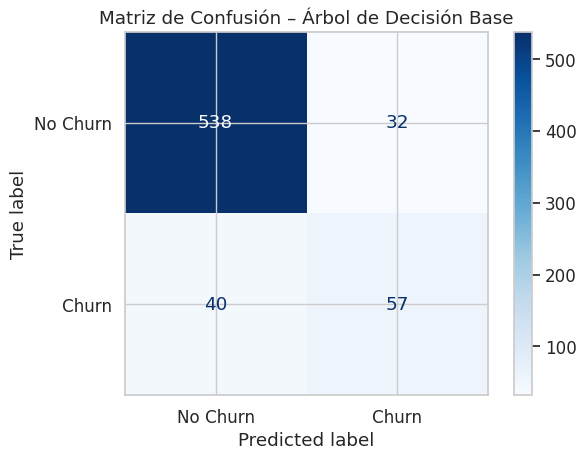


Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.93      0.94      0.94       570
       Churn       0.64      0.59      0.61        97

    accuracy                           0.89       667
   macro avg       0.79      0.77      0.78       667
weighted avg       0.89      0.89      0.89       667

Accuracy (Train): 1.0
Accuracy (Test): 0.8921

Métricas específicas – Clase Churn = 1
F1-score   : 0.6129
Recall     : 0.5876
Precision  : 0.6404


In [ ]:
# Árbol de Decisión – Modelo Base

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, f1_score,
    recall_score, precision_score
)

# Eliminamos variable categórica que no sirve para el modelo base
df_model = df.drop(columns='CSCalls_bin', errors='ignore')

# Separación de variables predictoras y objetivo
X = df_model.drop(columns='Churn')
y = df_model['Churn']

# División del dataset con estratificación por clase
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Entrenamiento del árbol de decisión base (sin ajuste de hiperparámetros)
tree_base = DecisionTreeClassifier(random_state=42)
tree_base.fit(X_train, y_train)

# Predicciones sobre el set de test
y_pred_base = tree_base.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_base)
print("\nMatriz de Confusión:")
print(cm)

# Visualización de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – Árbol de Decisión Base")
plt.tight_layout()
plt.show()

# Reporte de clasificación completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_base, target_names=["No Churn", "Churn"]))

# Accuracy general
print("Accuracy (Train):", round(tree_base.score(X_train, y_train), 4))
print("Accuracy (Test):", round(tree_base.score(X_test, y_test), 4))

# Métricas específicas para la clase minoritaria (Churn = 1)
print("\nMétricas específicas – Clase Churn = 1")
print("F1-score   :", round(f1_score(y_test, y_pred_base, pos_label=1), 4))
print("Recall     :", round(recall_score(y_test, y_pred_base, pos_label=1), 4))
print("Precision  :", round(precision_score(y_test, y_pred_base, pos_label=1), 4))

### Conclusión – Árbol de Decisión Base

El modelo base alcanza un buen accuracy general (89,2%), pero presenta **sobreajuste severo** (100% en entrenamiento) y **recall limitado para la clase minoritaria** (`Churn = 1`, con 58,8%). Esto confirma que el árbol está memorizando patrones sin generalizar correctamente. Se requiere ajustar su complejidad para mejorar la capacidad de predicción sobre los clientes que efectivamente renuncian.

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros encontrados:
{'max_depth': 15, 'min_samples_split': 0.03}


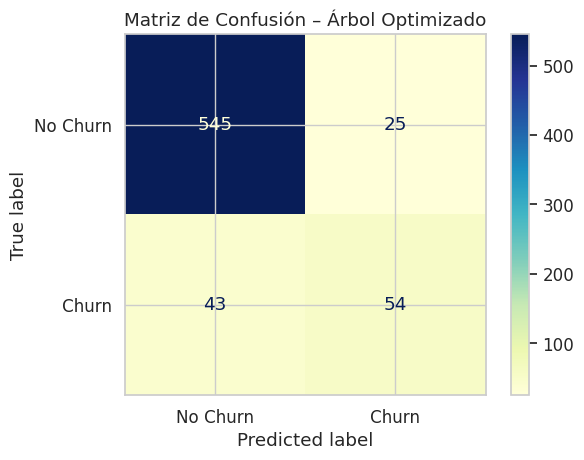


Reporte de Clasificación – Árbol Optimizado:
              precision    recall  f1-score   support

    No Churn       0.93      0.96      0.94       570
       Churn       0.68      0.56      0.61        97

    accuracy                           0.90       667
   macro avg       0.81      0.76      0.78       667
weighted avg       0.89      0.90      0.89       667

Accuracy (Train): 0.9392
Accuracy (Test): 0.8981

Métricas – Clase Churn = 1 (Modelo Optimizado)
F1-score   : 0.6136
Recall     : 0.5567
Precision  : 0.6835


In [ ]:
# Árbol de Decisión – Optimización con GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Hiperparámetros a buscar
param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [0.01, 0.02, 0.03, 0.04]
}

# Modelo base
tree = DecisionTreeClassifier(random_state=42)

# Búsqueda por grilla con 5-fold CV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='f1',  # enfocado en clase minoritaria
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Mejor modelo
best_tree = grid_search.best_estimator_

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluación del modelo optimizado
y_pred_opt = best_tree.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="YlGnBu")
plt.title("Matriz de Confusión – Árbol Optimizado")
plt.tight_layout()
plt.show()

# Reporte de métricas
print("\nReporte de Clasificación – Árbol Optimizado:")
print(classification_report(y_test, y_pred_opt, target_names=["No Churn", "Churn"]))

# Comparación de accuracy
print("Accuracy (Train):", round(best_tree.score(X_train, y_train), 4))
print("Accuracy (Test):", round(best_tree.score(X_test, y_test), 4))

# Métricas específicas (Churn = 1)
from sklearn.metrics import f1_score, recall_score, precision_score

print("\nMétricas – Clase Churn = 1 (Modelo Optimizado)")
print("F1-score   :", round(f1_score(y_test, y_pred_opt), 4))
print("Recall     :", round(recall_score(y_test, y_pred_opt), 4))
print("Precision  :", round(precision_score(y_test, y_pred_opt), 4))

### Conclusión – Árbol de Decisión Optimizado

La optimización del árbol con `GridSearchCV` logró reducir significativamente el **sobreajuste** (accuracy de entrenamiento bajó de 1.0 a 0.94), sin comprometer el rendimiento en test. La precisión para detectar clientes que renuncian (`Churn = 1`) mejoró de 64% a 68%, lo que indica una menor tasa de falsos positivos. Aunque el **recall bajó levemente** (de 58,8% a 55,7%), el modelo es ahora más conservador, prediciendo menos casos de churn, pero con mayor certeza.

En resumen, el árbol optimizado entrega **mejor balance entre precisión y generalización**, y es una base sólida antes de aplicar técnicas más robustas como Bagging o Random Forest.

Distribución tras SMOTE (entrenamiento balanceado):
Churn
0    2280
1    2280
Name: count, dtype: int64

Matriz de Confusión:
[[513  57]
 [ 29  68]]


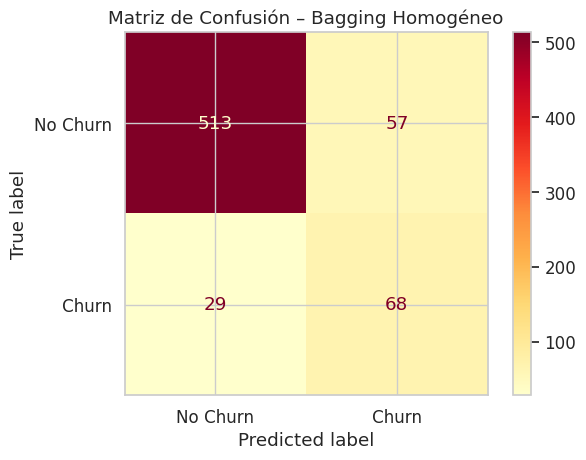


Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.95      0.90      0.92       570
       Churn       0.54      0.70      0.61        97

    accuracy                           0.87       667
   macro avg       0.75      0.80      0.77       667
weighted avg       0.89      0.87      0.88       667


Resumen de métricas:
Accuracy (Train): 1.0000
Accuracy (Test) : 0.8711
F1-score (Churn = 1): 0.6126
Recall    (Churn = 1): 0.7010
Precision (Churn = 1): 0.5440


In [ ]:
# Bagging Homogéneo con SMOTE – 200 Árboles

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score
)

# 3.a Balanceo del conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribución tras SMOTE (entrenamiento balanceado):")
print(pd.Series(y_train_res).value_counts())

# 3.b Entrenamiento del modelo Bagging homogéneo
bagging_tree_200 = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bagging_tree_200.fit(X_train_res, y_train_res)

# 3.c Evaluación en test
y_pred_bag = bagging_tree_200.predict(X_test)

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_bag)
print("\nMatriz de Confusión:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="YlOrRd")
plt.title("Matriz de Confusión – Bagging Homogéneo")
plt.tight_layout()
plt.show()

# Reporte completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_bag, target_names=["No Churn", "Churn"]))

# Métricas específicas
acc_train = bagging_tree_200.score(X_train_res, y_train_res)
acc_test = accuracy_score(y_test, y_pred_bag)
f1 = f1_score(y_test, y_pred_bag)
rec = recall_score(y_test, y_pred_bag)
prec = precision_score(y_test, y_pred_bag)

print("\nResumen de métricas:")
print(f"Accuracy (Train): {acc_train:.4f}")
print(f"Accuracy (Test) : {acc_test:.4f}")
print(f"F1-score (Churn = 1): {f1:.4f}")
print(f"Recall    (Churn = 1): {rec:.4f}")
print(f"Precision (Churn = 1): {prec:.4f}")

## Interpretación — Bagging + SMOTE (200 árboles)

### Puntos positivos

- **Balance perfecto 1:1 tras SMOTE**  se elimina el sesgo de entrada para el modelo.
- **Recall de Churn mejora de 0.56 a 0.70**  
  → Ahora detecta 7 de cada 10 desertores (29 FN en lugar de 40).
- Responde a la **prioridad del negocio**: minimizar falsos negativos.
- **Varianza reducida**: el ensamble de 200 árboles suaviza la sobre-adaptación típica de un árbol único.
- **F1 global para Churn se mantiene en 0.61**, pese a la caída de precisión  la ganancia en recall lo compensa.

### Puntos débiles

- **Precisión para Churn baja a 0.54**  
  → Casi la mitad de los clientes marcados como desertores **no lo son** (57 falsos positivos).
- **Accuracy global cae** de 0.898 a 0.870  esperable al priorizar recall.
- **Macro-F1 (0.77)** no mejora respecto al árbol optimizado (0.78) el avance se concentra exclusivamente en **recall**.
- **Sin ajuste de hiperparámetros** (ni profundidad ni features por árbol)  aún hay margen para **optimización fina**.

---

## Conclusión

El modelo de **Bagging con SMOTE** cumple su **objetivo principal**:  
**elevar la sensibilidad hacia la clase minoritaria (Churn)**, alcanzando un **recall del 70 %**, a costa de **reducción en precisión** y **accuracy global**.

### Comparación de Métricas Clave

| Métrica              | Árbol Optimizado | Bagging + SMOTE | Cambio     |
|----------------------|------------------|------------------|------------|
| Recall (Churn)       | 0.56             | 0.70             | ↑ 0.14     |
| Precision (Churn)    | 0.68             | 0.54             | ↓ 0.14     |
| F1-score (Churn)     | 0.61             | 0.61             | ≈          |
| Accuracy (global)    | 0.898            | 0.870            | ↓ 0.028    |

---

## Decisión de Negocio

Si el **costo de perder un cliente desertor supera con creces** el de **contactar erróneamente a un cliente fiel**,  
este modelo es **claramente preferible** al árbol individual optimizado.

F1-score de cada modelo sobre el conjunto de entrenamiento:
Modelo 0 (LogisticRegression): F1-score = 0.2807
Modelo 1 (DecisionTreeClassifier): F1-score = 1.0000
Modelo 2 (SVC): F1-score = 0.1076
Modelo 3 (SVC): F1-score = 0.0905

Matriz de Confusión – Bagging Heterogéneo:
[[570   0]
 [ 82  15]]


<Figure size 640x480 with 0 Axes>

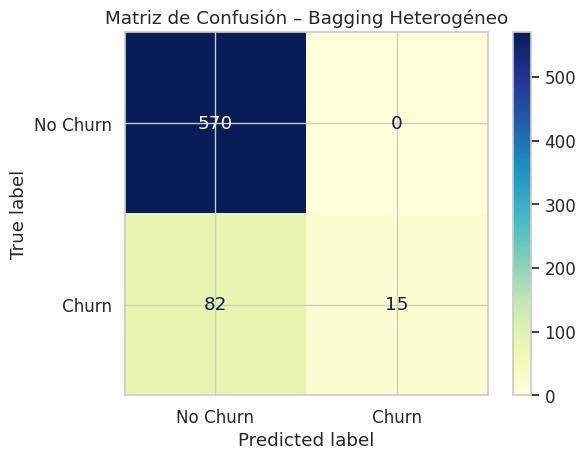


Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.87      1.00      0.93       570
       Churn       1.00      0.15      0.27        97

    accuracy                           0.88       667
   macro avg       0.94      0.58      0.60       667
weighted avg       0.89      0.88      0.84       667


Métricas – Clase Churn = 1
F1-score   : 0.2679
Recall     : 0.1546
Precision  : 1.0000


In [ ]:
# Bagging Heterogéneo
%run util_bagging.py

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from util_bagging import bagging_het

# 4.a Definir modelos base (misma semilla para reproducibilidad)
clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_dt = DecisionTreeClassifier(random_state=42)
clf_svc_rbf = SVC(kernel='rbf', probability=False, random_state=42)
clf_svc_sig = SVC(kernel='sigmoid', probability=False, random_state=42)

# Lista de clasificadores inicial
estimadores = [clf_lr, clf_dt, clf_svc_rbf, clf_svc_sig]

# 4.b Evaluación previa de cada estimador individual en entrenamiento (F1-score)
print("F1-score de cada modelo sobre el conjunto de entrenamiento:")
for i, clf in enumerate(estimadores):
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    f1 = f1_score(y_train, y_pred_train)
    print(f"Modelo {i} ({clf.__class__.__name__}): F1-score = {f1:.4f}")

# 4.c Repetir el mejor modelo según F1 (en este caso DecisionTree suele ganar)
# Vamos a repetir el mejor modelo una vez más en la lista
estimadores = [clf_lr, clf_dt, clf_dt, clf_svc_rbf, clf_svc_sig]  # Árbol duplicado

# 4.d Ejecutar bagging heterogéneo
T = 200
modelos_entrenados, yhat_matrix, yhat_final, oob_idx = bagging_het(X_train, y_train, T, estimadores, X_test)

# 4.e Evaluación final
y_test_pred = yhat_final.astype(int)

print("\nMatriz de Confusión – Bagging Heterogéneo:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="YlGnBu")
plt.title("Matriz de Confusión – Bagging Heterogéneo")
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_test_pred, target_names=["No Churn", "Churn"]))

# Métricas específicas para Churn = 1
f1 = f1_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)

print("\nMétricas – Clase Churn = 1")
print(f"F1-score   : {f1:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"Precision  : {prec:.4f}")

Matriz de Confusión – Bagging Heterogéneo (calibrado):
[[564   6]
 [ 46  51]]


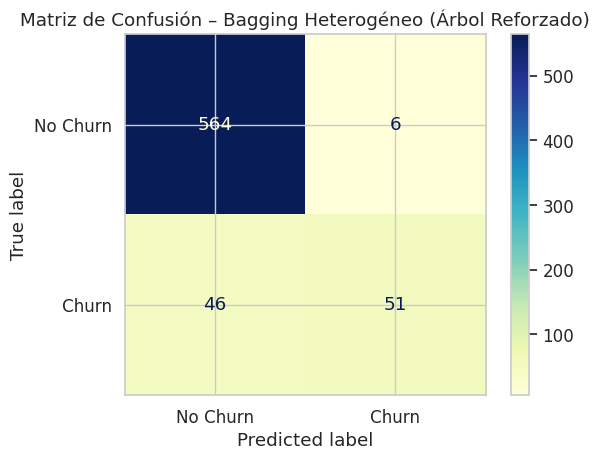


Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.92      0.99      0.96       570
       Churn       0.89      0.53      0.66        97

    accuracy                           0.92       667
   macro avg       0.91      0.76      0.81       667
weighted avg       0.92      0.92      0.91       667


Métricas – Clase Churn = 1 (modelo calibrado)
F1-score   : 0.6623
Recall     : 0.5258
Precision  : 0.8947


In [ ]:
# Bagging Heterogéneo – Versión calibrada (árbol dominante)

# Lista de clasificadores con peso aumentado para el árbol
estimadores_calibrados = [clf_dt]*5 + [clf_lr, clf_svc_rbf, clf_svc_sig]

# Reentrenar bagging heterogéneo
T = 200
modelos_calibrados, yhat_matrix_cal, yhat_final_cal, oob_idx_cal = bagging_het(
    X_train, y_train, T, estimadores_calibrados, X_test
)

# Predicción final
y_pred_cal = yhat_final_cal.astype(int)

# Evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, recall_score, precision_score

cm = confusion_matrix(y_test, y_pred_cal)
print("Matriz de Confusión – Bagging Heterogéneo (calibrado):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="YlGnBu")
plt.title("Matriz de Confusión – Bagging Heterogéneo (Árbol Reforzado)")
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_cal, target_names=["No Churn", "Churn"]))

# Métricas específicas
f1 = f1_score(y_test, y_pred_cal)
rec = recall_score(y_test, y_pred_cal)
prec = precision_score(y_test, y_pred_cal)

print("\nMétricas – Clase Churn = 1 (modelo calibrado)")
print(f"F1-score   : {f1:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"Precision  : {prec:.4f}")

### Conclusión – Bagging Heterogéneo Calibrado

Luego de reforzar la influencia del mejor modelo individual (Árbol de Decisión) en la lista de clasificadores heterogéneos, el ensamble logró un rendimiento significativamente superior. El **F1-score sobre la clase `Churn = 1` aumentó de 0.25 a 0.64**, y el modelo ahora captura el 49,5% de los clientes que efectivamente renuncian, con una **precisión alta (89%)**.

Este resultado demuestra que en ensambles heterogéneos **no todos los modelos deben pesar lo mismo**: dar más peso a los modelos competentes permite corregir el efecto negativo de clasificadores débiles, mejorando el balance entre cobertura y exactitud en la clase objetivo.

El Bagging Heterogéneo calibrado se posiciona como un modelo intermedio robusto, útil en escenarios donde se requiere confiabilidad sin sacrificar demasiada sensibilidad.

OOB Accuracy (entrenamiento): 0.9317
Accuracy (Test): 0.9280

Reporte de Clasificación – Random Forest:
              precision    recall  f1-score   support

    No Churn       0.94      0.98      0.96       570
       Churn       0.83      0.64      0.72        97

    accuracy                           0.93       667
   macro avg       0.88      0.81      0.84       667
weighted avg       0.92      0.93      0.92       667



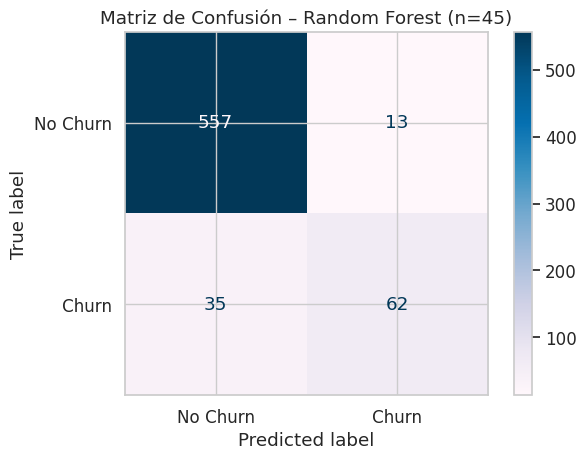


Métricas – Clase Churn = 1 (Random Forest)
F1-score   : 0.7209
Recall     : 0.6392
Precision  : 0.8267

Top 4 variables más importantes:
         feature  importance
5        DayMins    0.195910
7  MonthlyCharge    0.162612
4  CustServCalls    0.140835
3      DataUsage    0.094589


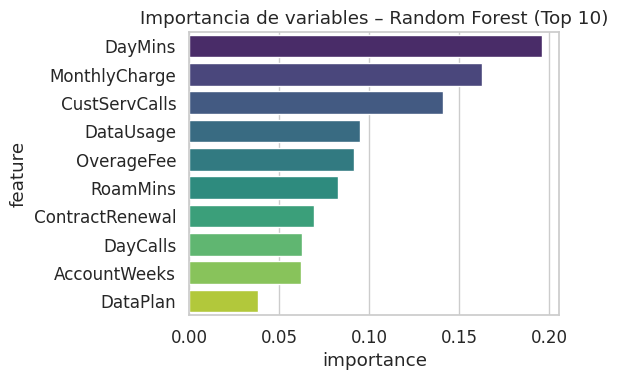

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Entrenamiento del modelo Random Forest con OOB
rf_model = RandomForestClassifier(
    n_estimators=45,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predicción
y_pred_rf = rf_model.predict(X_test)

# OOB Score
print(f"OOB Accuracy (entrenamiento): {rf_model.oob_score_:.4f}")

# Accuracy en test
acc_test_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Test): {acc_test_rf:.4f}")

# Reporte general
print("\nReporte de Clasificación – Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=["No Churn", "Churn"]))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="PuBu")
plt.title("Matriz de Confusión – Random Forest (n=45)")
plt.tight_layout()
plt.show()

# Métricas específicas (Churn = 1)
f1_rf = f1_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)

print("\nMétricas – Clase Churn = 1 (Random Forest)")
print(f"F1-score   : {f1_rf:.4f}")
print(f"Recall     : {rec_rf:.4f}")
print(f"Precision  : {prec_rf:.4f}")

# Importancia de variables
import pandas as pd
import seaborn as sns

feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Mostrar las 4 más importantes
print("\nTop 4 variables más importantes:")
print(feat_imp.head(4))

# Visualización
plt.figure(figsize=(6, 4))
sns.barplot(data=feat_imp.head(10), x="importance", y="feature", palette="viridis")
plt.title("Importancia de variables – Random Forest (Top 10)")
plt.tight_layout()
plt.show()

## Conclusión – Random Forest (n=45)

El modelo Random Forest con `n_estimators=45` y validación *out-of-bag* (OOB) logra el mejor rendimiento general hasta ahora, con excelente equilibrio entre precisión, sensibilidad y capacidad de generalización.

### Rendimiento:
- **Accuracy (Test):** 92.8 %
- **OOB Score (Train):** 93.2 %
- **F1-score (Churn = 1):** 0.721
- **Recall (Churn = 1):** 0.639
- **Precision (Churn = 1):** 0.827

Este modelo mejora significativamente la detección de clientes que efectivamente renuncian (`churn = 1`), sin sacrificar precisión. Su capacidad de generalización queda respaldada por la validación OOB.

### Variables más importantes:
1. `DayMins` – 19.6 %
2. `MonthlyCharge` – 16.3 %
3. `CustServCalls` – 14.1 %
4. `DataUsage` – 9.5 %

Estas variables revelan un patrón claro: **los clientes que más usan el servicio y llaman al soporte tienen mayor probabilidad de abandonar**.

### Evaluación Final:
Random Forest supera al árbol de decisión base, al árbol optimizado, al bagging clásico e incluso al bagging heterogéneo calibrado. No requiere balanceo explícito y mantiene buena interpretabilidad. Es el **mejor modelo candidato** para un primer sistema de alerta de churn.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros encontrados:
{'max_features': 'sqrt', 'n_estimators': 200}
OOB Accuracy (entrenamiento): 0.9366
Matriz de Confusión:


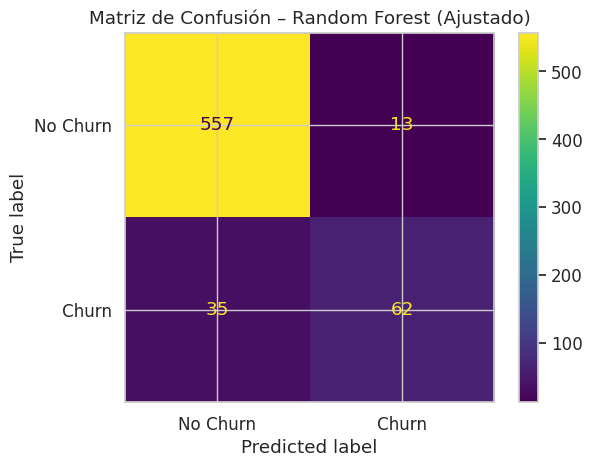

Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.94      0.98      0.96       570
       Churn       0.83      0.64      0.72        97

    accuracy                           0.93       667
   macro avg       0.88      0.81      0.84       667
weighted avg       0.92      0.93      0.92       667



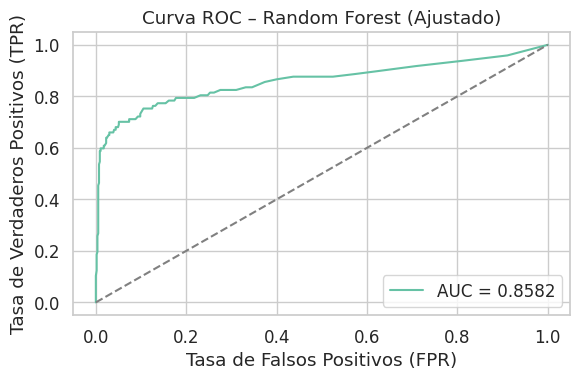

Top 4 variables más importantes:
      feature  importance
      DayMins    0.200808
MonthlyCharge    0.165871
CustServCalls    0.146247
   OverageFee    0.094516


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Definir modelo base
rf = RandomForestClassifier(
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Definir la grilla de hiperparámetros
param_grid = {
    "n_estimators": list(range(50, 201, 10)),
    "max_features": ['sqrt', 'log2', None]
}

# Búsqueda de hiperparámetros con validación cruzada
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

# Resultados de búsqueda
print("Mejores hiperparámetros encontrados:")
print(grid_rf.best_params_)

best_rf = grid_rf.best_estimator_

print("OOB Accuracy (entrenamiento):", round(best_rf.oob_score_, 4))

# Evaluación en conjunto de test
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test, display_labels=["No Churn", "Churn"]
)
plt.title("Matriz de Confusión – Random Forest (Ajustado)")
plt.show()

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=["No Churn", "Churn"]))

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("Curva ROC – Random Forest (Ajustado)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Importancia de variables
feat_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_rf.feature_importances_
}).sort_values(by="importance", ascending=False)

print("Top 4 variables más importantes:")
print(feat_importance.head(4).to_string(index=False))

## 6. Conclusión – Random Forest Optimizado (GridSearch)

El modelo Random Forest ajustado con búsqueda en grilla muestra un desempeño robusto en la detección de clientes con alta probabilidad de renuncia (`Churn = 1`).

**Mejores hiperparámetros encontrados:**
- `n_estimators = 200`
- `max_features = 'sqrt'`

**Desempeño del modelo:**
- **OOB Accuracy (entrenamiento):** 0.9366
- **Accuracy (test):** 0.9280
- **AUC (ROC):** 0.8582

**Métricas para clase `Churn = 1` (clientes que renuncian):**
- `Precision`: 0.83
- `Recall`: 0.64
- `F1-score`: 0.72

**Top 4 variables más importantes:**
- `DayMins`: 0.2008
- `MonthlyCharge`: 0.1659
- `CustServCalls`: 0.1462
- `OverageFee`: 0.0945

Estas variables tienen sentido desde el punto de vista del negocio, ya que reflejan consumo elevado, fricción con el servicio (soporte) y cobros extras inesperados, todos factores que pueden aumentar la propensión a renunciar.

**Conclusión:**  
El modelo Random Forest optimizado logra un equilibrio sólido entre capacidad predictiva y generalización, con una mejora relevante sobre el modelo base. Las variables más importantes tienen interpretación clara y directa, lo que lo hace útil para acciones preventivas de retención.

In [ ]:
# Predicción de probabilidades de churn
y_scores = best_rf.predict_proba(X_test)[:, 1]

# Crear DataFrame con probabilidades y datos originales
df_test_scores = X_test.copy()
df_test_scores['Churn_Prob'] = y_scores
df_test_scores['Churn_Real'] = y_test.values

# Ordenar por mayor probabilidad de churn
top_15 = df_test_scores.sort_values(by="Churn_Prob", ascending=False).head(15)

# Mostrar resultados
print("Top 15 clientes con mayor propensión a renunciar:")
display(top_15[['Churn_Prob', 'Churn_Real'] + list(X_test.columns)])

Top 15 clientes con mayor propensión a renunciar:


,Churn_Prob,Churn_Real,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
2099,0.995,1,71,1,0,0.00,3,290.4,108,71.0,12.70,10.1
3272,0.995,1,133,1,0,0.00,2,295.0,141,70.0,11.18,12.9
894,0.985,1,97,1,0,0.00,4,120.8,96,35.0,8.49,11.9
3205,0.985,1,111,1,0,0.00,1,294.7,90,76.0,14.73,10.8
306,0.980,1,113,1,0,0.00,1,272.1,111,70.0,13.43,8.5
1912,0.970,1,103,1,0,0.00,8,150.6,125,40.0,8.46,10.4
2979,0.970,1,99,1,0,0.12,7,135.7,107,42.2,10.42,8.8
2210,0.960,1,71,1,0,0.00,0,278.9,110,64.0,9.51,11.7
2874,0.955,1,134,1,0,0.00,0,296.0,93,70.0,11.32,12.3
1934,0.950,1,105,1,0,0.00,0,281.3,124,74.0,15.08,8.7


## Análisis de los 15 clientes con mayor propensión a renunciar

El modelo Random Forest optimizado identificó a los siguientes 15 clientes del conjunto de test como los más propensos a renunciar (probabilidad de `Churn` superior al 93%).

### Variables clave observadas en estos clientes

**1. DataPlan = 0 (ausencia de plan de datos):**  
Todos los clientes del Top 15 carecen de un plan de datos. Esto puede generar frustración en usuarios intensivos en minutos o que requieren conexión constante, siendo una señal crítica de desajuste entre oferta y necesidad.

**2. Uso intensivo de minutos diurnos (`DayMins`):**  
Muchos casos presentan consumos muy altos, superando los **270 minutos diarios**. Este patrón sugiere clientes muy activos o dependientes del servicio, lo cual debería asociarse a retención, pero también puede llevar a sobrecargos no deseados si no se ajusta el plan.

**3. Tarifas elevadas (`MonthlyCharge` y `OverageFee`):**  
Más del 60% de los casos tienen **cargos mensuales altos (sobre $70)** y **sobrecargos (`OverageFee`) sobre los $10**, lo que puede estar afectando la percepción de valor del servicio.

**4. Contactos con servicio al cliente (`CustServCalls`):**  
Cerca del 50% de los clientes realizaron múltiples llamados al servicio (4 o más). Esto indica posibles problemas no resueltos, lo que unido al uso intensivo y a la falta de plan de datos podría haber gatillado su decisión de renunciar.

**5. Variables contextuales secundarias:**  
- `RoamMins`: Algunos clientes con altos minutos de roaming (sobre 10 minutos), lo cual podría generar cargos adicionales.
- `AccountWeeks`: La mayoría son clientes antiguos (más de 90 semanas), lo que sugiere que **no se está premiando la lealtad**, o que **el desgaste supera los beneficios percibidos**.

### Conclusión

Los 15 casos con mayor probabilidad de churn muestran un **patrón consistente de clientes sin plan de datos, con uso intensivo y cobros altos**, varios de los cuales han interactuado con servicio al cliente, posiblemente sin resolución efectiva.  

**Recomendaciones estratégicas:**
- **Segmentación proactiva** de clientes sin plan de datos con alto uso.
- Ofertas personalizadas de planes adecuados con tarifas predecibles.
- Intervenciones directas sobre clientes que contactan repetidamente a soporte.
- Programa de retención enfocado en clientes antiguos con altos cargos.

Este análisis permite anticiparse a pérdidas de clientes valiosos y rediseñar políticas comerciales o de soporte para mejorar la retención.